# How does the performance of a distributional model change as we train in on more and more labelled data?

 - Pennington el al (2014) report `word2vec`'s performance at the word analogy task and a range of word similarity task improves with more data. 
 - My own experiments (in `euroscipy_demo` notebook) show performance at the analogy task roughly scales like $log(x)$

Let's investigate if the same holds for the document classification task. For simiplicity, we only look at `word2vec` vectors with simple composion on the Reuters data set.

In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from gui.output_utils import *

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [8]:
corpus_sizes = {'cwiki': 525000000, 'wiki':1500000000}

def get_exp_ids_for_varying_amounts_of_unlabelled(lab_corpus, unlab=['wiki'], k=3):
    query_dict = {'expansions__vectors__rep': 0, 
                  'expansions__k':k,
                  'labelled':lab_corpus,
                'expansions__use_similarity': 0, 
                'expansions__neighbour_strategy':'linear',
                'expansions__vectors__dimensionality': 100, 
                'document_features_ev': 'AN+NN', 
                'document_features_tr': 'J+N+AN+NN', 
                'expansions__allow_overlap': False,
                'expansions__entries_of': None,
                'expansions__vectors__algorithm': 'word2vec',
                'expansions__vectors__composer__in': ['Add', 'Mult', 'Left', 'Right'], # todo Verb???
                'expansions__vectors__unlabelled__in': unlab,
                'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
                'expansions__noise': 0}
    return Experiment.objects.filter(**query_dict).order_by('expansions__vectors__unlabelled_percentage',
                                                           'expansions__vectors__composer').values_list('id', flat=True)

# convert percentages to token counts
def compute_token_count(row):
    corpus_sizes = {'cwiki': 525000000, 'wiki':1500000000}
    return corpus_sizes[row.unlab] * (row.percent / 100)


def plot(lab_corpus, unlab, k=3):
    ids = get_exp_ids_for_varying_amounts_of_unlabelled(lab_corpus, unlab, k=k)
    print(len(ids), 'ids in total:', ids)
    cols = {'Composer':'expansions__vectors__composer',
            'percent':'expansions__vectors__unlabelled_percentage',
            'unlab': 'expansions__vectors__unlabelled'}
    df = dataframe_from_exp_ids(ids, cols).convert_objects(convert_numeric=True)
#     df['tokens'] = corpus_sizes[] * df.percent.values / 100
    
    df['tokens'] = df.apply(compute_token_count, axis=1)
    df['Method'] = df.unlab + '-' + df.Composer
    ax = sns.tsplot(df, time='tokens', condition='Method', value='Accuracy', 
                    unit='folds', linewidth=4, ci=68);
    # remove axis labels  
    ax.set(xlabel='Tokens', ylabel='Accuracy')

    # random baseline
    plt.axhline(random_vect_baseline(lab_corpus), label='RandV', color='black')
    plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
    return df, ax

44 ids in total: [101, 351, 113, 107, 119, 102, 353, 114, 108, 120, 75, 352, 77, 76, 78, 103, 354, 115, 109, 121, '...(remaining elements truncated)...']
percent has 22000 values
folds has 22000 values
unlab has 22000 values
Composer has 22000 values
Accuracy has 22000 values


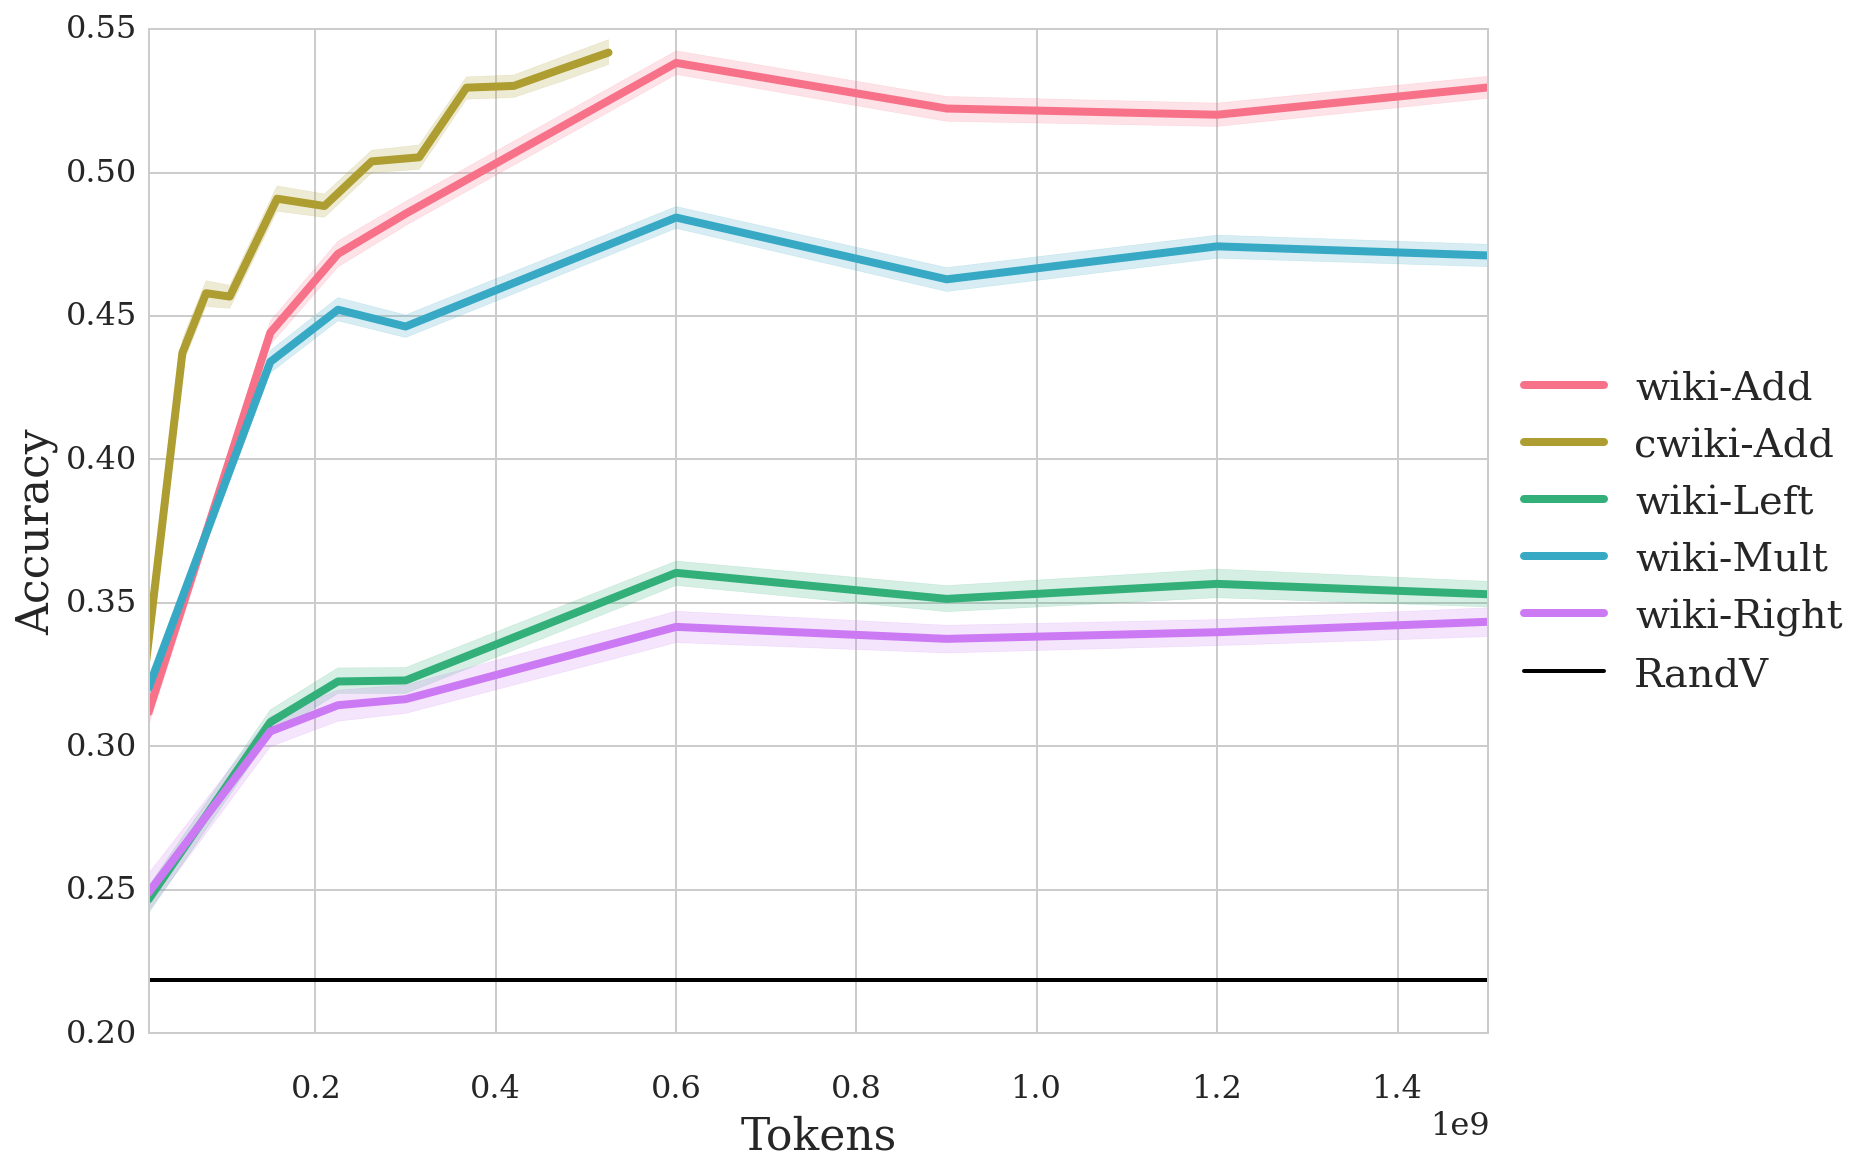

In [5]:
with sns.color_palette("cubehelix", 4):
    df1, ax = plot('amazon_grouped-tagged', ['wiki', 'cwiki'])
plt.savefig('plot-w2v_learning_curve_amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

45 ids in total: [125, 147, 136, 158, 126, 148, 137, 159, 364, 127, 149, 138, 160, 128, 150, 139, 161, 130, 152, 141, '...(remaining elements truncated)...']
percent has 22500 values
folds has 22500 values
unlab has 22500 values
Composer has 22500 values
Accuracy has 22500 values


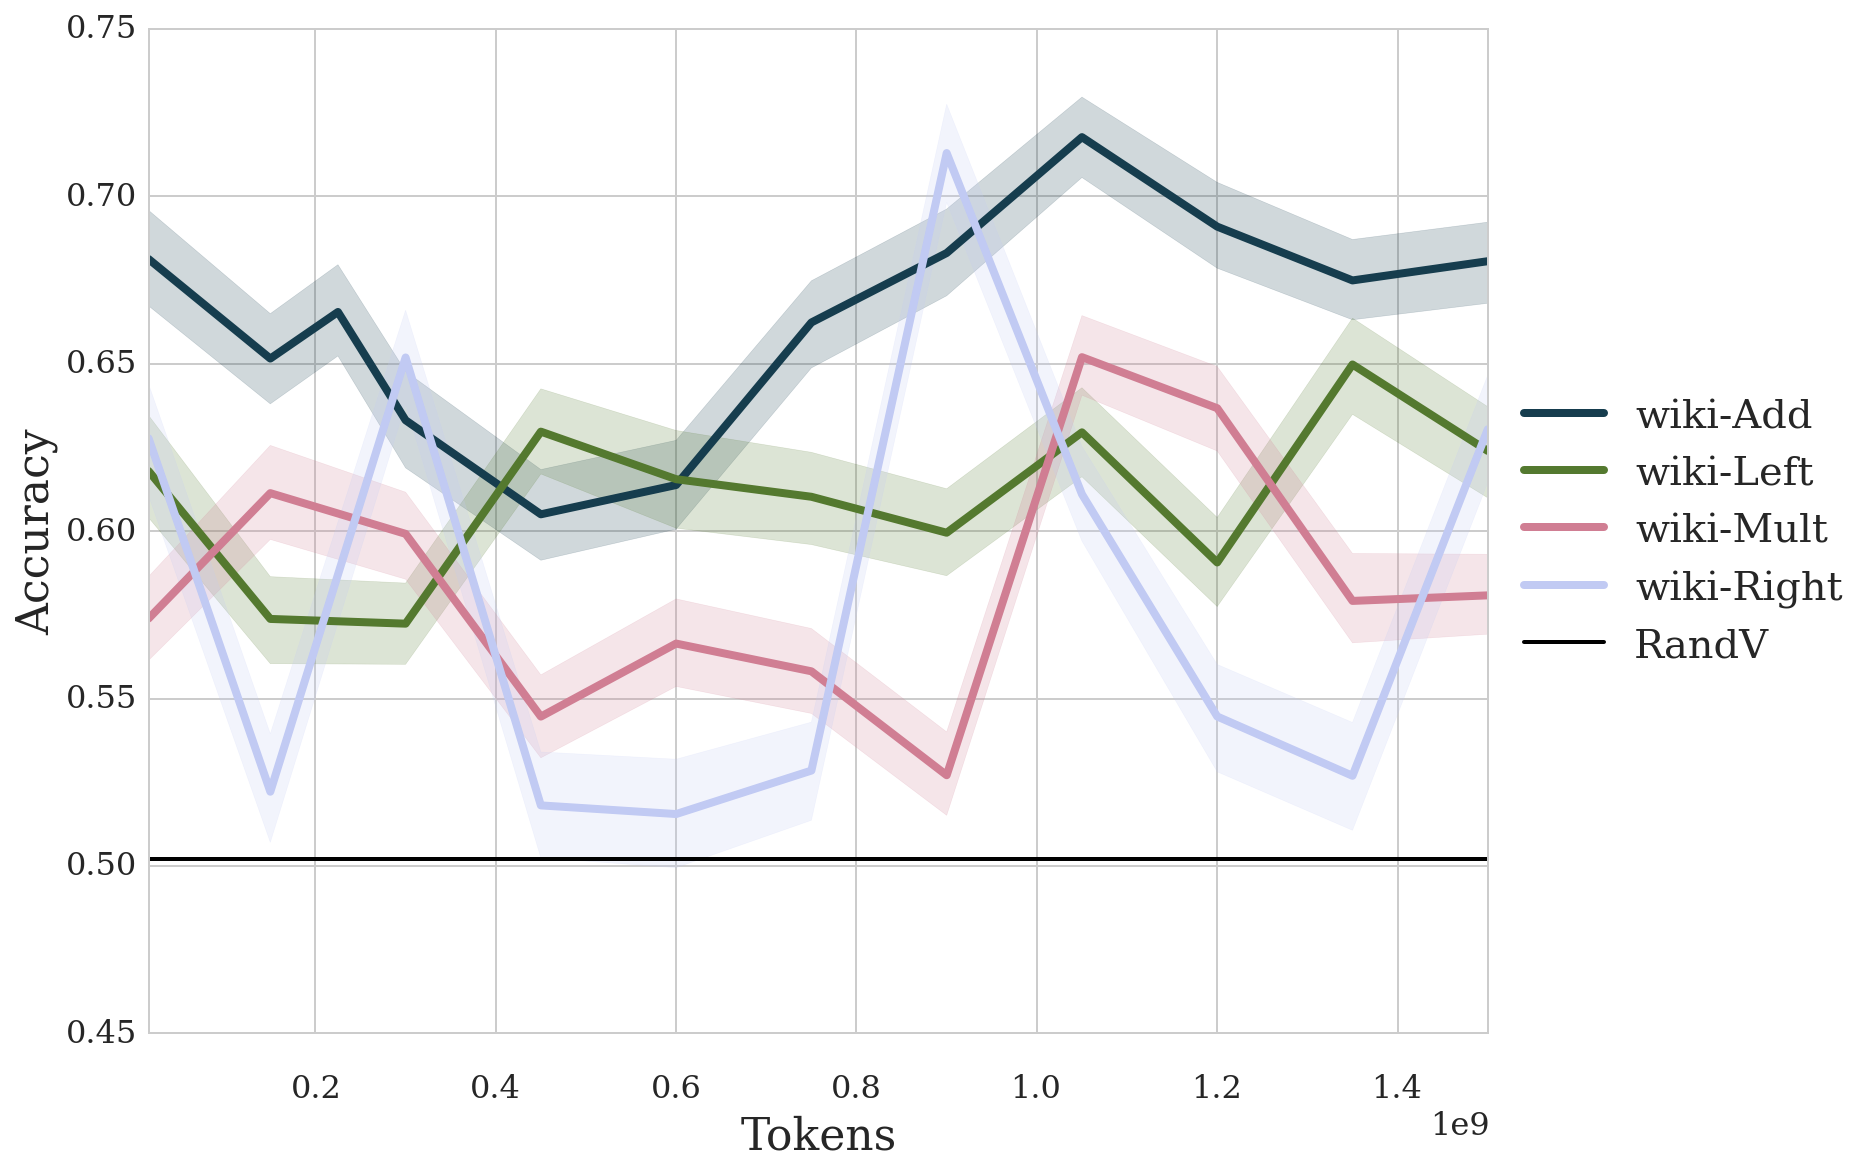

In [6]:
with sns.color_palette("cubehelix", 4):
    plot('reuters21578/r8-tagged-grouped', ['wiki'])
plt.savefig('plot-w2v_learning_curve_r2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

41 ids in total: [433, 453, 443, 463, 434, 454, 444, 464, 435, 455, 445, 465, 436, 456, 446, 466, 438, 458, 448, 468, '...(remaining elements truncated)...']
percent has 20500 values
folds has 20500 values
unlab has 20500 values
Composer has 20500 values
Accuracy has 20500 values
Calculating CI for exp 453
Calculating CI for exp 443
Calculating CI for exp 433
Calculating CI for exp 463
Calculating CI for exp 464
Calculating CI for exp 454
Calculating CI for exp 444
Calculating CI for exp 434
Calculating CI for exp 465
Calculating CI for exp 445
Calculating CI for exp 435
Calculating CI for exp 455
Calculating CI for exp 466
Calculating CI for exp 446
Calculating CI for exp 436
Calculating CI for exp 456
Calculating CI for exp 458
Calculating CI for exp 448
Calculating CI for exp 438
Calculating CI for exp 468
Calculating CI for exp 467
Calculating CI for exp 457
Calculating CI for exp 437
Calculating CI for exp 447
Calculating CI for exp 459
Calculating CI for exp 469
Calculating CI fo

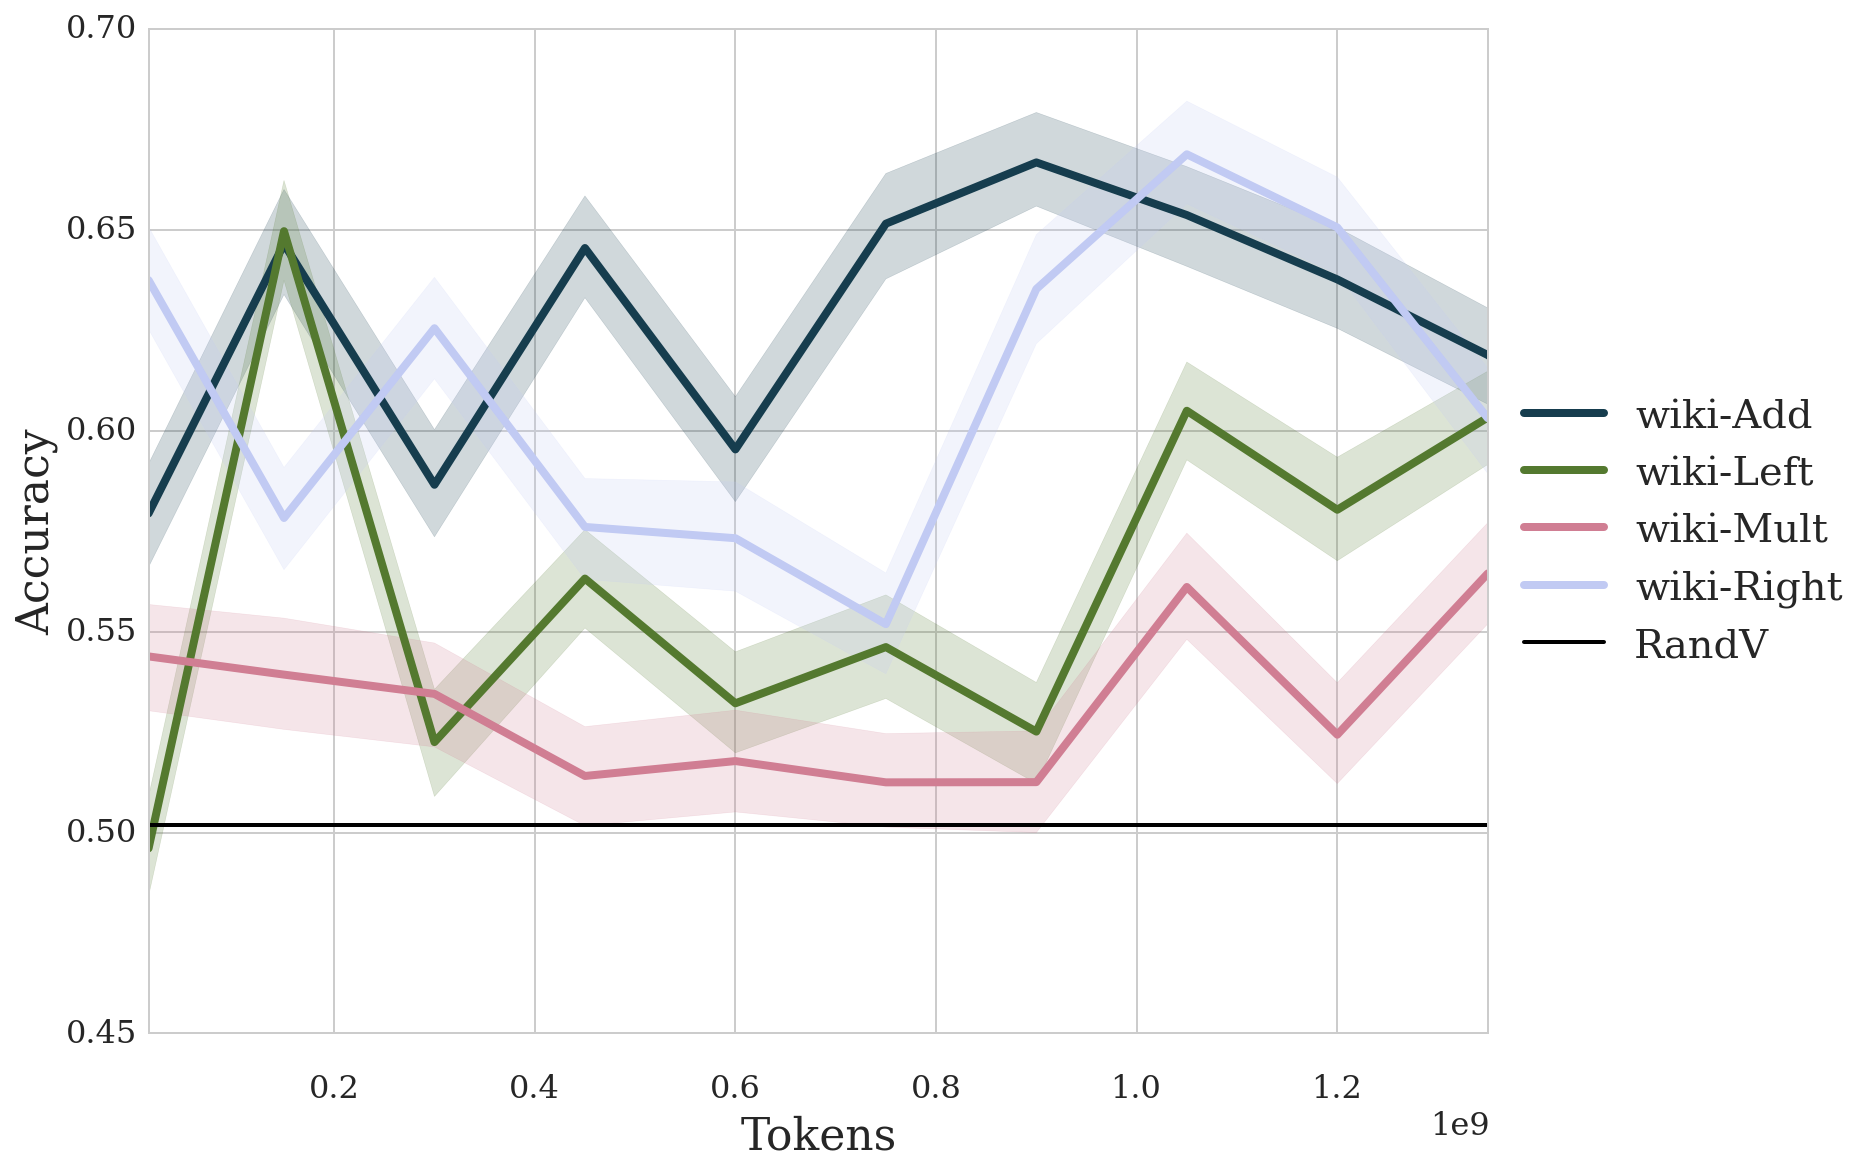

In [9]:
with sns.color_palette("cubehelix", 4):
    plot('reuters21578/r8-tagged-grouped', ['wiki'], k=30)
plt.savefig('plot-w2v_learning_curve_r2-k30.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

41 ids in total: [473, 493, 483, 503, 474, 494, 484, 504, 475, 495, 485, 505, 476, 496, 486, 506, 478, 498, 488, 508, '...(remaining elements truncated)...']
percent has 20500 values
folds has 20500 values
unlab has 20500 values
Composer has 20500 values
Accuracy has 20500 values
Calculating CI for exp 483
Calculating CI for exp 493
Calculating CI for exp 473
Calculating CI for exp 503
Calculating CI for exp 474
Calculating CI for exp 504
Calculating CI for exp 494
Calculating CI for exp 484
Calculating CI for exp 475
Calculating CI for exp 505
Calculating CI for exp 485
Calculating CI for exp 495
Calculating CI for exp 476
Calculating CI for exp 506
Calculating CI for exp 496
Calculating CI for exp 486
Calculating CI for exp 478
Calculating CI for exp 508
Calculating CI for exp 498
Calculating CI for exp 488
Calculating CI for exp 477
Calculating CI for exp 507
Calculating CI for exp 487
Calculating CI for exp 497
Calculating CI for exp 479
Calculating CI for exp 509
Calculating CI fo

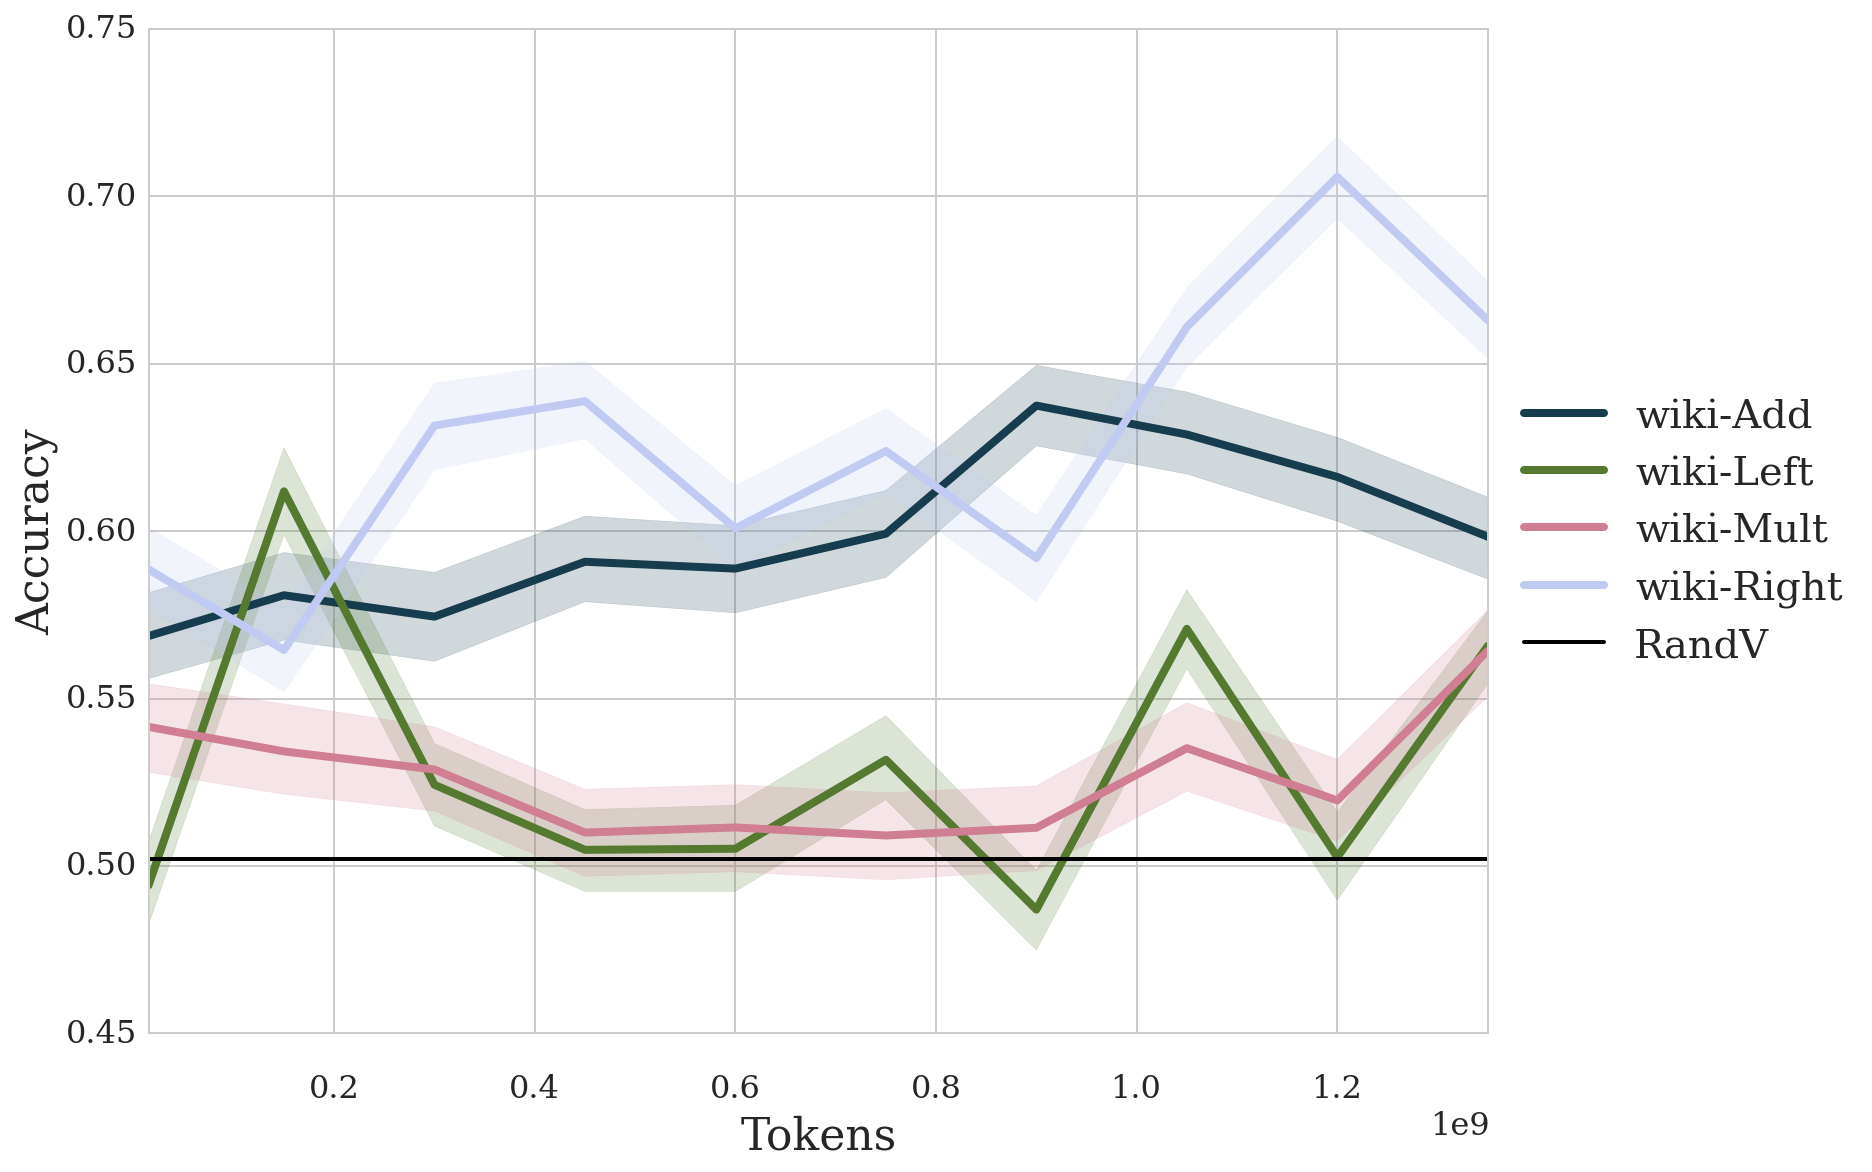

In [10]:
with sns.color_palette("cubehelix", 4):
    plot('reuters21578/r8-tagged-grouped', ['wiki'], k=60)
plt.savefig('plot-w2v_learning_curve_r2-k60.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# A different style of plot (with smoothing) 

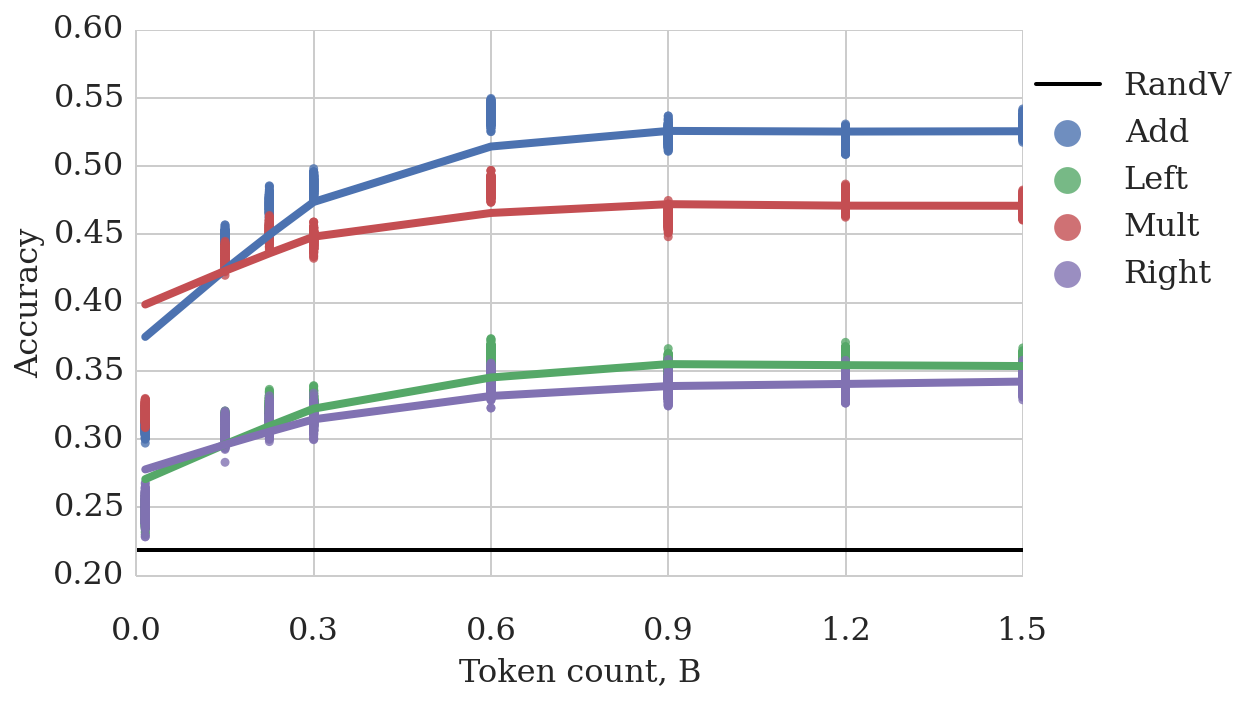

In [5]:
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.labelsize'] = 16

# do main plot
df['Algorithm'] = df.Composer
g = sns.lmplot('percent', 'Accuracy', df, hue='Algorithm', lowess=True, 
               line_kws={"linewidth": 4}, # line size
               legend=False, # hide legend for now, I'll show it later
               aspect=1.5);

labels = np.arange(0, 101, 20) * 0.01 * 1.5 # convert percent of corpus to a rough token count
g.set(xlim=(0,100), xticklabels=labels, xlabel='Token count, B')

# add random baseline
plt.axhline(random_vect_baseline(), color='k', label='RandV');

# add a legend with extra bits and bobs
plt.legend(markerscale=3,
#            bbox_to_anchor=(0., 1.02, 1., .102), 
           bbox_to_anchor=(1., .5), 
           loc=3,
           ncol=1,
           borderaxespad=0.)
g.savefig('plot-w2v_learning_curve_amazon2.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

#---------------------------------------------------------------------------
#---------------------------------------------------------------------------
# Notes on code below
In earlier iterations of this experiment we used Reuters data, where there was large variation between accuracies of multiple runs of the `word2vec`. The code below looks into why that might be the case. These differences no longer exist, so the code below is probably useless.

# Why is multiply so unstable?
Things to look at
- <s>compare vectors between multiple runs (before and after composition)</s>. The space is completely different, this makes no sense.
 - compare neighbours of a sample of entries between runs
  - without any constraints, out of the full vocabulary
  - out of the neighbours present in the labelled data set
      - redoing experiments [218, 313, 314] and [225, 315, 316] with stats enabled. These are word2vec repeated runs at 100% of gigaw with Add/Mult composer respectively
  
- Could the whole variation be simply down to the small size of Reuters? Would using Amazon help? 
  - in general error bounds due to classification task are much smaller on Amazon (~1%) as apposed to ~3-4% on Reuters

- Performance of `w2v` models I've trained on google's analogy task
    - can't easily calculate as I have stemmed and added a pos tar => syntactic part of test is impossible to do
    - compute something like Precision@K/MAP instead of accuracy of top neighbour

 - Neighbour do not overlap much (not to mention their order)
 - Should I report averaged performance across all runs of `word2vec`?
 
If the neighbours vary so much, why is the performance of some composers so stable? 
  - Do some composers "magnify" differences in input vectors?
  - Is it a matter of vocabulary coverage? the neighbours that we find here are different to the one the classifier finds